In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pysilsub.problem import SilentSubstitutionProblem as SSP
from pysilsub.CIE import get_CIES026

In [2]:
# Functions for stimulus waveform
def get_time_vector(duration):
    t = np.arange(0, (duration*1000), 10).astype("int")
    return t


def sinusoid_modulation(f, duration, Fs=50):
    x = np.arange(duration * Fs)
    sm = np.sin(2 * np.pi * f * x / Fs)
    return sm


def modulate_intensity_amplitude(sm, background, amplitude):
    ivals = (background + (sm*amplitude)).astype("int")
    return ivals

/Users/jtm545/opt/anaconda3/envs/silsub/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: inplace is deprecated and will be removed in a future version.
  


************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: BCGAR (12-bit, nonlinear)
Background: [0.5, 0.5, 0.5, 0.5, 0.5]
Ignoring: ['R']
Silencing: ['M', 'L', 'I']
Isolating: ['S']
Target contrast: 2.0
Bounds: [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]


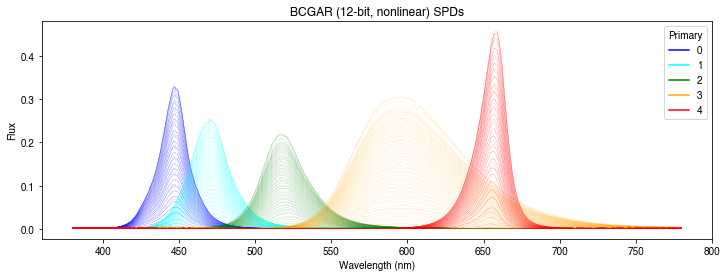

In [3]:
# Load the calibration data
spds = pd.read_csv(
    '../data/S2_corrected_oo_spectra.csv', 
    index_col=['Primary','Setting'])
spds.columns = pd.Int64Index(spds.columns.astype(int))
spds.columns.name = 'Wavelength'
spds = spds.drop(labels=[0,2,4,6,8]).reset_index().set_index(['Primary','Setting'])
spds.index.set_levels([0,1,2,3,4], level='Primary', inplace=True)

# List of colors for the primaries
colors = ['blue', 'cyan', 'green', 'orange', 'red'] 

ssp = SSP(
    resolutions=[4095]*5,  # Five 12-bit primaries 
    colors=colors,  # Colors of the LEDs
    spds=spds,  # The calibration data
    spd_binwidth=1,  # SPD wavelength binwidth
    ignore=['R'],  # Ignore rods
    silence=['M', 'L', 'I'],  # Silence S-, M-, and L-cones
    isolate=['S'],  # Isolate melanopsin
    target_contrast=2.,  # Aim for 250% contrast 
    name='BCGAR (12-bit, nonlinear)',
    background=[.5]*5  # Description of device
) 

spd_fig = ssp.plot_spds()

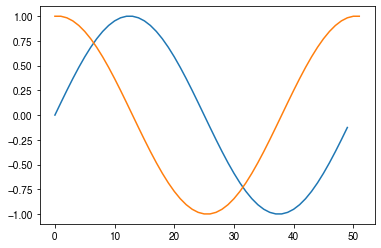

In [4]:
# Target contrast vals for modulation
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * 1.
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

S-cone contrast modulation
==========================

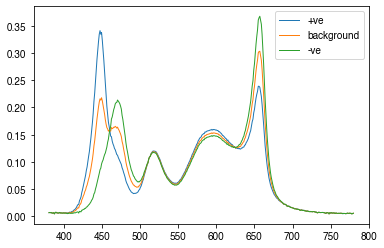

In [5]:
# Calcualte modulation spectra for S-cone modulation
contrast_mods = [ssp.linalg_solve([tc, 0, 0, 0]) for tc in target_contrasts]

plt.plot(ssp.predict_multiprimary_spd(contrast_mods[0]), lw=1, label='+ve')
plt.plot(ssp.predict_multiprimary_spd(ssp.background), lw=1, label='background')
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[-1]), lw=1, label='-ve')
plt.legend()


Modulation peak
---------------

	Background luminance: 8839.893851070427
	Modulation luminance: 8896.476181954102
	Background xy: [ 0.35553014  0.30123822]
	Modulation xy: [ 0.33822794  0.27384263]
S-cone contrast: 0.25129520835877117
Splatter: Photoreceptor
M    0.006771
L    0.006248
R    0.007558
I    0.005077
dtype: float64


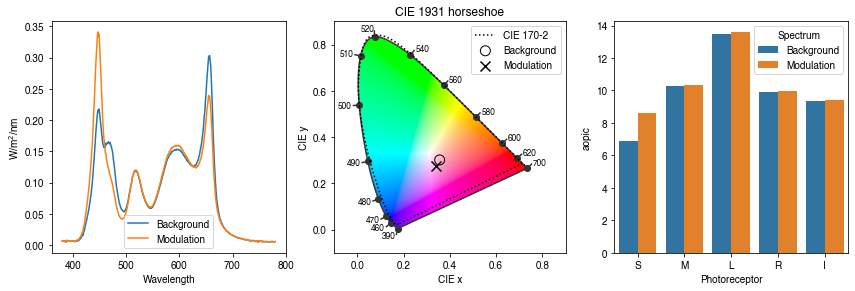

In [6]:
ssp.plot_ss_result(contrast_mods[0])
contrasts = ssp.get_photoreceptor_contrasts(contrast_mods[0])
print(f'S-cone contrast: {contrasts[0]}')
print(f'Splatter: {contrasts[1:]}')

Modulation trough
-----------------

	Background luminance: 8839.893851070427
	Modulation luminance: 8805.816315083304
	Background xy: [ 0.35553014  0.30123822]
	Modulation xy: [ 0.37947119  0.33862123]
S-cone contrast: -0.27220433224878166
Splatter: Photoreceptor
M   -0.004893
L   -0.003446
R   -0.009743
I   -0.008999
dtype: float64


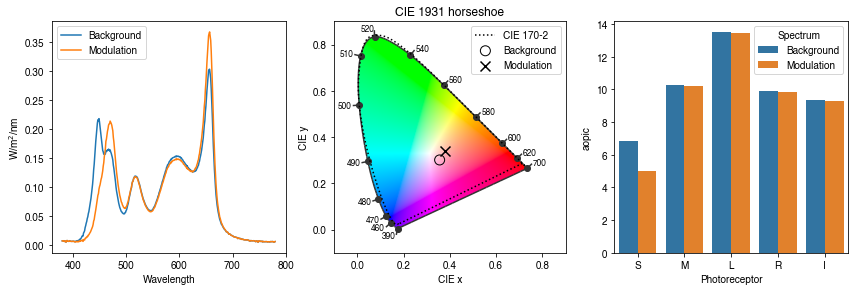

In [7]:
ssp.plot_ss_result(contrast_mods[-1])
contrasts = ssp.get_photoreceptor_contrasts(contrast_mods[-1])
print(f'S-cone contrast: {contrasts[0]}')
print(f'Splatter: {contrasts[1:]}')

Contrast modulations
--------------------

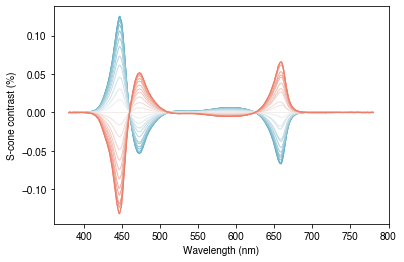

In [8]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ssp.predict_multiprimary_spd(ssp.background)
for i, s in enumerate(contrast_mods):
    mod_spd = ssp.predict_multiprimary_spd(s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');

Splatter
--------

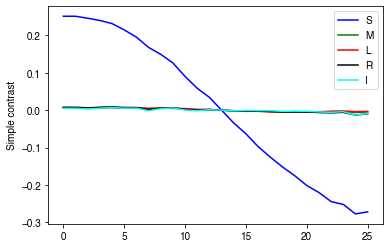

In [9]:
splatter = [ssp.get_photoreceptor_contrasts(cm) for cm in contrast_mods]
splatter = np.vstack(splatter)

plt.plot(splatter[:,0], label='S', c='b')
plt.plot(splatter[:,1], label='M', c='g')
plt.plot(splatter[:,2], label='L', c='r')
plt.plot(splatter[:,3], label='R', c='k')
plt.plot(splatter[:,4], label='I', c='cyan')
plt.ylabel('Simple contrast')
plt.legend()

Melanopsin modulation
---------------------

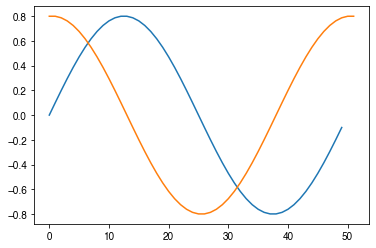

In [19]:
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * .8
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

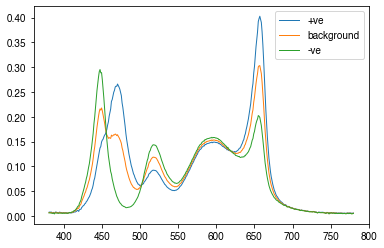

In [21]:
ssp.isolate = ['I']
ssp.silence = ['S', 'M', 'L']

contrast_mods = [ssp.linalg_solve([0, 0, 0, tc]) for tc in target_contrasts]
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[0]), lw=1, label='+ve')
plt.plot(ssp.predict_multiprimary_spd(ssp.background), lw=1, label='background')
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[-1]), lw=1, label='-ve')
plt.legend()

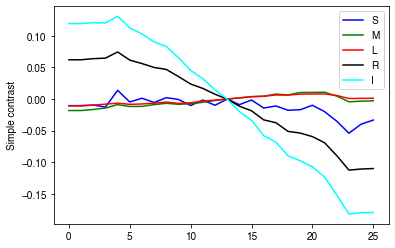

In [22]:
splatter = [ssp.get_photoreceptor_contrasts(cm) for cm in contrast_mods]
splatter = np.vstack(splatter)

plt.plot(splatter[:,0], label='S', c='b')
plt.plot(splatter[:,1], label='M', c='g')
plt.plot(splatter[:,2], label='L', c='r')
plt.plot(splatter[:,3], label='R', c='k')
plt.plot(splatter[:,4], label='I', c='cyan')
plt.ylabel('Simple contrast')
plt.legend()

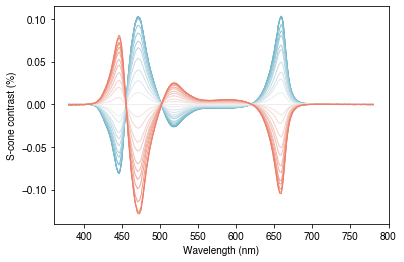

In [23]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ssp.predict_multiprimary_spd(ssp.background)
for i, s in enumerate(contrast_mods):
    mod_spd = ssp.predict_multiprimary_spd(s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');